(chap_formation_spatial)=
# Blur & the PSF

:::{admonition} Chapter outline
:class: tip

* Measurements in fluorescence microscopy are affected by **blur**
* Blur acts as a convolution with the microscope's **Point Spread Function (PSF)**
* The size of the PSF depends on the **microscope type**, **light wavelength** & **objective lens Numerical Aperture (NA)**, and is on the order of hundreds of nm
* In the focal plane, the PSF is an **Airy pattern**
* **Spatial resolution** is a measure of how close structures can be distinguished.
It's better in _xy_ than along the _z_ dimension.
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

Microscopy images normally look blurry because light originating from one point in the sample is not all detected at a single pixel: usually it is detected over several pixels and _z_-slices.
This is _not_ simply because we cannot use perfect lenses; rather, it's caused by a fundamental limit imposed by the nature of light.
The end result is as if the light that we detect is redistributed slightly throughout our data ({numref}`fig-castles`).

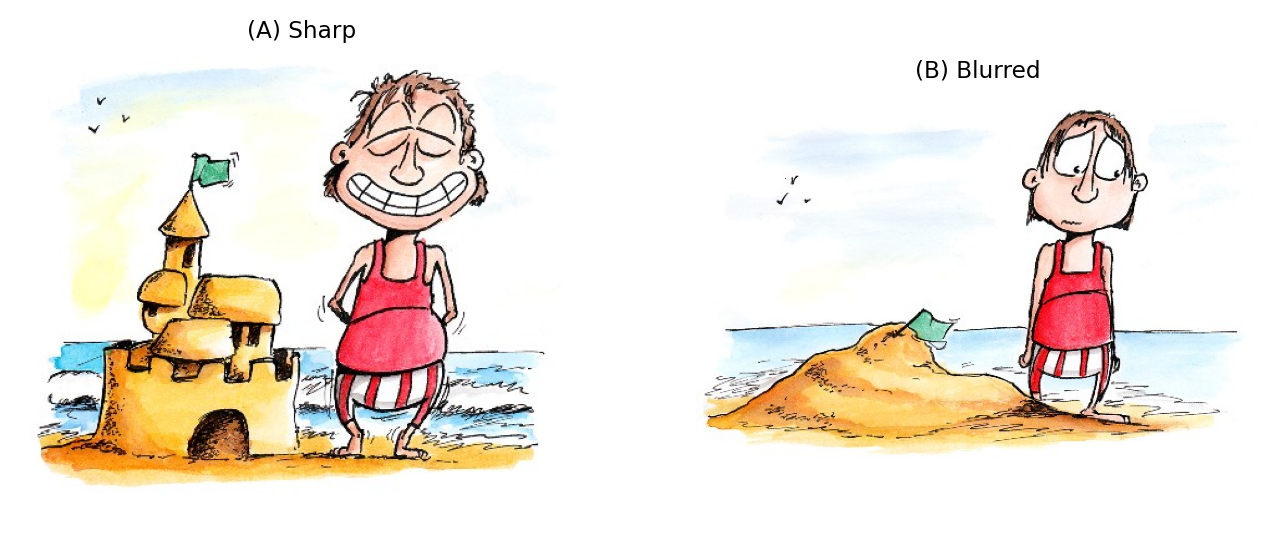

In [2]:
fig = create_figure(figsize=(8, 4))
show_image('images/castle_sharp.jpg', title='(A) Sharp', pos=121)
show_image('images/castle_convolved.jpg', title='(B) Blurred', pos=122)
glue_fig('fig_blur_castles', fig)

```{glue:figure} fig_blur_castles
---
align: center
name: fig-castles
---
Schematic diagram showing the effects of blur. Think of the sand as photons, and the [height of the sandcastle as the intensity values of pixels](fig-transform_surface) (a greater height indicates more photons, and thus a brighter pixel). The ideal data would be sharp and could contain fine details (A), but after blurring it's not only harder to discriminate details, but intensities in the brighter regions have been reduced and sizes increased (B). If we then wish to determine the size or height of one of the sandcastle's towers, for example, we need to remember that any results we get by measuring (B) will differ from those we would have got if we could have measured (A) itself. Note, however, that approximately the same _amount_ of signal (sand or photons) is present in both cases –- only the arrangement has been changed.
```

This is important for three reasons:

1.  Blur affects the apparent **size** of structures
2.  Blur affects the apparent **intensity** (i.e. brightnesses) of structures
3.  Blur (sometimes) affects the apparent **number** of structures

Therefore, _almost every measurement_ we might want to make can be affected by blurring to some degree.

That's the bad news about blur.
The good news is that it's rather well understood, and we can take some comfort that it is not random.
In fact, the main ideas have already been described in {ref}`chap_filters`, because blurring in fluorescence microscopy is mathematically described by a **convolution** involving the microscope's **Point Spread Function (PSF)**.
In other words, the PSF acts like a linear filter applied to the perfect, sharp data we would like but can never directly acquire.

Previously, we saw how smoothing (e.g. mean or Gaussian) filters could helpfully reduce noise, but as the filter size increased we would [lose more and more detail](chap_filters_gaussian_size).
At that time, we could choose the size and shapes of filters ourselves, changing them arbitrarily by modifying coefficients to get the noise-reduction vs. lost-detail balance we liked best.
But the microscope's blurring differs in at least two important ways.
Firstly, it's effectively applied to our data _before_ noise gets involved, so offers no noise-reduction benefits.
Secondly, because it occurs before we ever set our eyes on our images, the size and shape of the filter used (i.e. the PSF) are only indirectly (and in a very limited way) under our control.
It would therefore be much nicer just to dispense with the blurring completely since it offers no real help, but unfortunately light conspires to make this not an option: we just need to cope with it.

The purpose of this chapter is to offer a practical introduction to why the blurring occurs, what a widefield microscope's PSF looks like, and why all this matters.
Detailed optics and threatening integrals are not included, although several equations make appearances.
Fortunately for the mathematically unenthusiastic, these are both short and useful.

## Blur & convolution

As stated above, the fundamental cause of blur is that light originating from an infinitesimally small point cannot then be detected at a similar point, no matter how great our lenses or detectors might be.
Rather, it ends up being focused to some larger volume known as the PSF, which has a minimum size dependent upon both the light's wavelength and the lens being used.

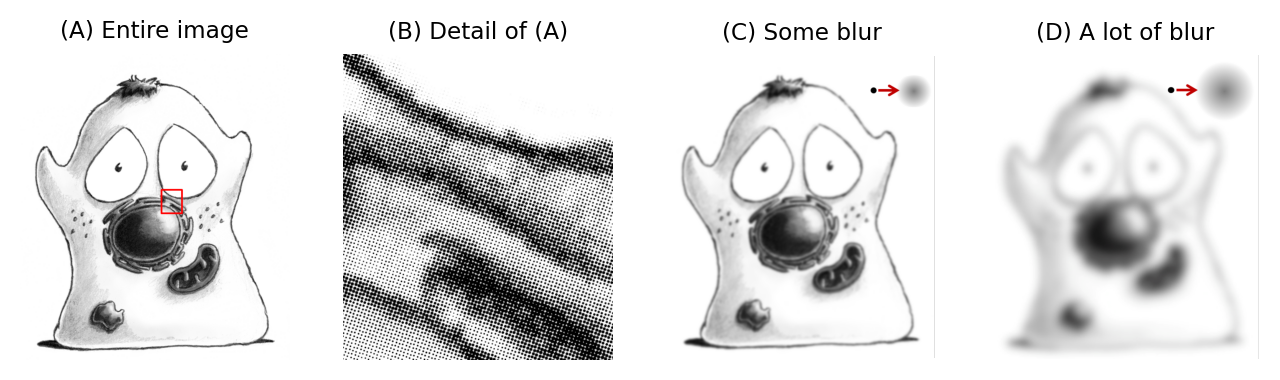

In [3]:
fig = create_figure(figsize=(8, 4))
show_image('images/psf_sizes_orig.png', title='(A) Entire image', pos=141)
show_image('images/psf_sizes_detail.png', title='(B) Detail of (A)', pos=142)
show_image('images/psf_sizes_small.png', title='(C) Some blur', pos=143)
show_image('images/psf_sizes_large.png', title='(D) A lot of blur', pos=144)
glue_fig('fig_blur_psf_sizes', fig)

```{glue:figure} fig_blur_psf_sizes
---
align: center
name: fig-psf_sizes
---
Although it might not be obvious at low magnification (A), an image can be viewed as composed of small points (B). This gives us a useful way to understand what has happened in a blurred image: each point has simply been replaced by a more diffuse blob, the PSF. Images appear more or less blurred depending upon how large the blobby PSFs are \(C) and (D). This is equivalent to applying the PSF to an image as a linear filter.
```


This becomes more practically relevant if we consider that _any_ fluorescing sample can be viewed as composed of many similar, exceedingly small light-emitting points -- you may think of each point being a fluorophore.
Our image would ideally then include individual points too, digitized into pixels with values proportional to the emitted light.
But what we get instead is an image in which every point has been replaced by its PSF, scaled according to the point's brightness.
Where these PSFs overlap, the detected light intensities are simply added together.
Exactly how blurry this causes the image to be depends upon the size of the PSF ({numref}`fig-psf_sizes`).

This blurring process is equivalent to **convolving** the (impossible) ideal point image with the PSF: i.e. applying a linear filter, as described in {ref}`chap_filters`.
Because every point is blurred in the same way (at least in the ideal case; extra aberrations can cause some variations), this means that if we know the PSF then we can characterize the blur throughout the entire image -- and thereby make inferences about the extent to which blurring will impact upon anything we measure.

## The shape of the PSF

We can gain an initial impression of a microscope's PSF by recording a *z*-stack of a small, fluorescent bead, which represents an ideal light-emitting point.
{numref}`fig-psf_bead` shows that, for a widefield microscope, the bead appears like a bright blob when it is in focus.
More curiously, when viewed from the side (__xz__ or __yz__), it has a somewhat hourglass-like appearance -- albeit with some extra patterns.
This exact shape is well enough understood that PSFs can also be generated theoretically based upon the type of microscope and objective lenses used (C).

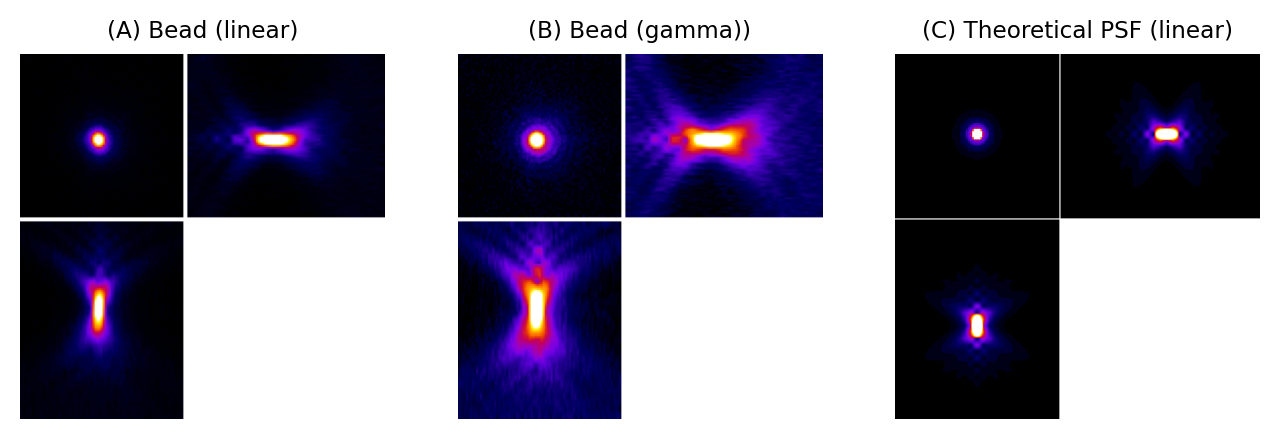

In [4]:
fig = create_figure(figsize=(8, 4))
show_image('images/bead_linear.png', title='(A) Bead (linear)', pos=131)
show_image('images/bead_gamma.png', title='(B) Bead (gamma))', pos=132)
show_image('images/bead_theoretical.png', title='(C) Theoretical PSF (linear)', pos=133)
glue_fig('fig_blur_psf_bead', fig)

```{glue:figure} fig_blur_psf_bead
---
align: center
name: fig-psf_bead
---
PSFs for a widefield microscope. (A) and (B) are from z-stacks acquired of a small fluorescent bead, displayed using linear contrast and after applying a gamma transform to make fainter details easier to discern (see {ref}`chap_point_operations` for more information). \(C) shows a theoretical PSF for a similar microscope. It differs in appearance partly because the bead is not really an infinitesimally small point, and partly because the real microscope's objective lens is less than perfect. Nevertheless, the overall shapes are similar.
```



:::{admonition} Generating PSFs
:class: info

ImageJ plugins to create theoretical PSFs are available from
* <https://imagej.net/Diffraction_PSF_3D>
* <http://bigwww.epfl.ch/algorithms/psfgenerator/>
:::

### In & out of focus

{numref}`fig-psf_planes` attempts to show that the hourglass aspect of the PSF is really perfectly intuitive.
When recording a *z*-stack of a light-emitting point, we would _prefer_ that the light ended up at a single pixel in a single slice.
But the light itself is oblivious to our wishes, and will cheerfully be detected if it happens to strike a detector, no matter where that is.
Therefore we should expect the light to be detected across a small region only if the image is in-focus; otherwise it will be spread out to an extent that depends upon how far from the focal point it is detected.
From the side (__xz__ or __yz__), this leads to an hourglass shape.

```{figure} images/psf_diagram.png
---
align: center
width: 90%
name: fig-psf_planes
---
Simplified diagram to help visualize how a light-emitting point would be imaged using a widefield microscope. Some of the light originating from the point is captured by a lens. If you imagine the light then being directed towards a focal point, this leads to an hourglass shape. If a detector is placed close to the focal point, the spot-like image formed by the light striking the detector would be small and bright. However, if the detector were positioned above or below this focal plane, the intensity of the spot would decrease and its size would increase.
```

````{tab-set}

```{tab-item} Question


In focus, a light-emitting point looks like a small, bright blob.
Out of focus, it's much less bright and extends over a wider area.

However, how would you expect the _total amount_ of light to differ in a widefield image depending upon whether a plane is in-focus or not?
In other words, would you expect more or less light in the focal plane than in other planes above or below it?

```


```{tab-item} Answer

In a widefield image, every plane we can record contains in-focus light along with _all_ the detectable light from _all_ other planes added together.
Therefore we should expect approximately _the same total amount of light_ within each plane of a *z*-stack – just differently distributed.
That's potentially a lot of light in the 'wrong' place, especially if looking at a thick sample.

At least, this would be so for an infinitely-large detector, or a small, centered sample.
In practice, if the light originates from a location so out-of-focus that its light spills over the side of the detector then this plane would contain less light.
```

````

### The appearance of interference

{numref}`fig-psf_planes` is quite limited in what it shows: it doesn't begin to explain the extra patterns of the PSF, which appear on each 2D plane as concentric rings (see {numref}`fig-bead_slices`) nor why the PSF doesn't shrink to a single point in the focal plane.
These factors relate to the interference of light waves.
While it's important to know that the rings occur -- if only to avoid ever misinterpreting them as extra ring-like structures being really present in a sample -- they have limited influence upon any analysis because the central region of the PSF is overwhelmingly brighter.
Therefore for our purposes they can mostly be disregarded.

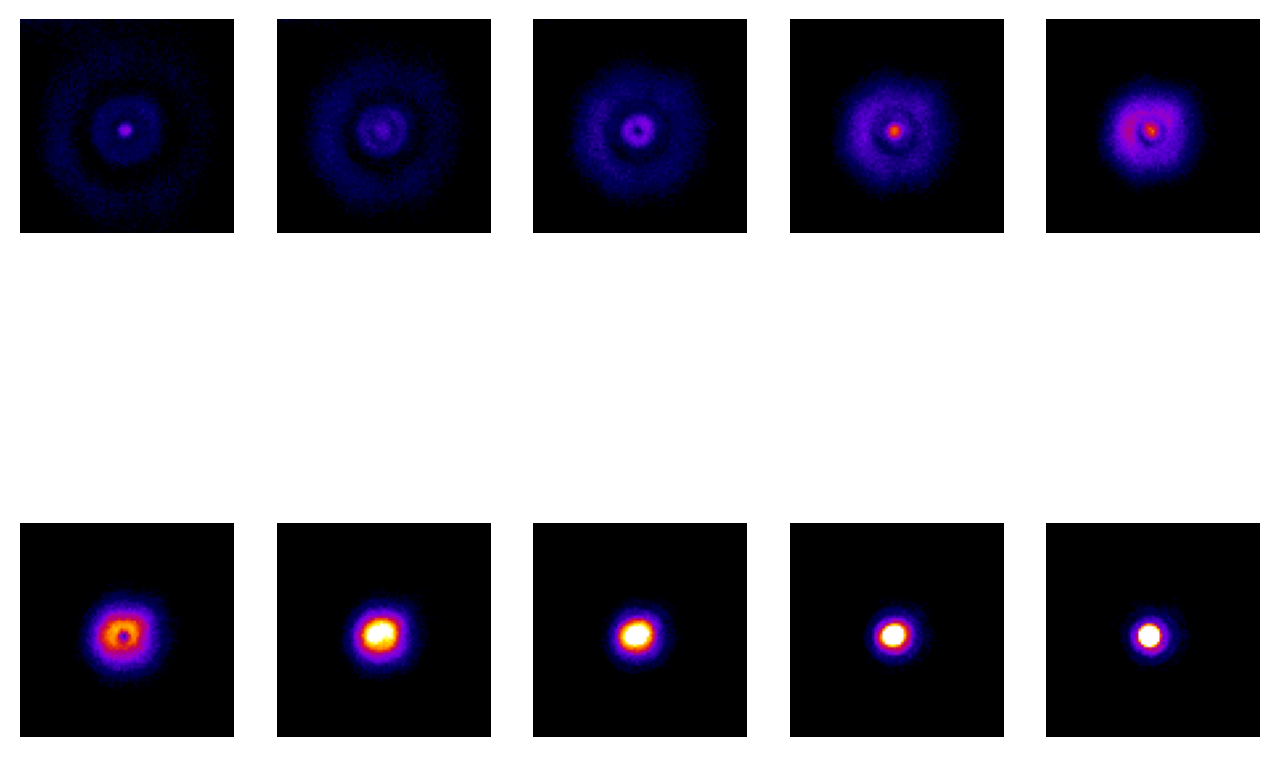

In [5]:
fig = create_figure(figsize=(8, 6))
for ii in range(10):
    show_image(f'images/bead_slices_{ii}.png', pos=(2, 5, ii+1))

glue_fig('fig_blur_bead_slices', fig)

```{glue:figure} fig_blur_bead_slices
---
align: center
name: fig-bead_slices
---
Ten slices from a z-stack acquired of a fluorescent bead, starting from above and moving down to the focal plane. The same linear contrast settings have been applied to each slice for easy comparison, although this causes the in-focus bead to appear saturated since otherwise the rings would not be visible at all. Because the image is (approximately) symmetrical along the z-axis, additional slices moving below the focal plane would appear similar.
```


#### The Airy disk

Finally for this section, the PSF in the focal plane is important enough to deserve some attention, since we tend to want to measure things where they are most in-focus.
This entire *xy* plane, including its interfering ripples, is called an **Airy pattern**, while the bright central part alone is the **Airy disk** ({numref}`fig-airy`).
In the best possible case, when all the light in a 2D image comes from in-focus structures, what we can image would already have been blurred by a filter that looks like this.

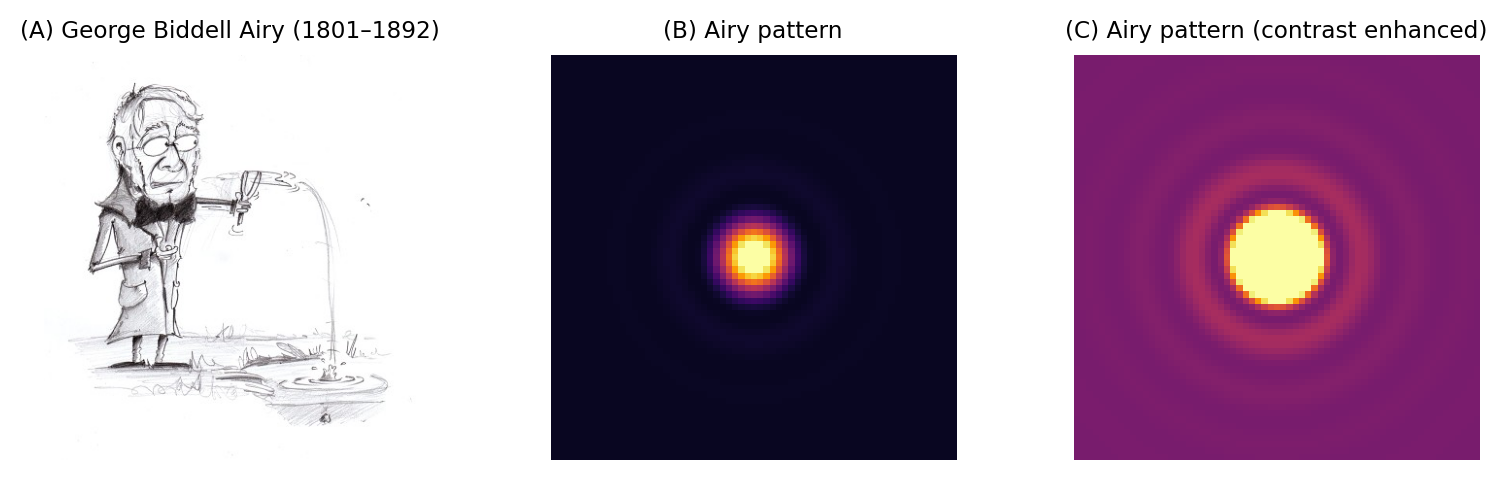

In [6]:
def demo_airy_disk(radius=10, size=128):
    """
    Create an Airy disk image for illustration.

    Parameters:
     radius: radius of the Airy disk, in pixels
     size:   width and height of the image, in pixels
    """
    from scipy.special import j1

    s = 3.83 / radius
    x = np.arange(size, dtype=np.float64) * s
    x -= x.mean()
    y, x = np.meshgrid(x, x)
    r = np.sqrt(x*x + y*y)
    result = np.ones(r.shape)
    result[r != 0] = (2 * j1(r[r != 0]) / r[r != 0])**2
    return result, y, x

from matplotlib import colormaps

cmap = colormaps['inferno']
im_airy, y, x = demo_airy_disk(radius = 10, size = 65)

fig = create_figure(figsize=(8, 2.5))
# ax_cartoon = fig.add_subplot(1, 3, 1)
# ax_disk = fig.add_subplot(1, 3, 2)
# ax_3d = fig.add_subplot(1, 3, 3, projection='3d', elev=20)

show_image('images/Airy.jpg', title='(A) George Biddell Airy (1801–1892)', pos=131)
show_image(im_airy, title='(B) Airy pattern', vmin=-0.05, vmax=0.8, cmap=cmap, pos=132)
show_image(im_airy, title='(C) Airy pattern (contrast enhanced)', vmin=-0.05, vmax=0.1, cmap=cmap, pos=133)

plt.tight_layout()
glue_fig('fig_blur_airy', fig)

```{glue:figure} fig_blur_airy
---
align: center
name: fig-airy
---
George Biddell Airy and the Airy pattern. (A) During his schooldays, Airy had been renowned for being skilled _'in the construction of peashooters and other such devices'_ (see <https://mathshistory.st-andrews.ac.uk/Biographies/Airy/>).
The rings surrounding the Airy disk have been likened to the ripples on a pond.
Although the rings phenomenon was already known, Airy wrote the first theoretical treatment of it in 1835 (<https://en.wikipedia.org/wiki/Airy_disk>).
(B) An Airy pattern looks much like a 2D Gaussian function, although when the contrast is enhanced (C) small outer rings can be seen surrounding the Airy disk.
```


The Airy disk should look familiar.
If we ignore the little interfering ripples around its edges, it can be very well approximated by a Gaussian function ({numref}`fig-psf_surface`).
Therefore _the blur of a microscope in 2D is similar to applying a Gaussian filter_, at least in the focal plane.

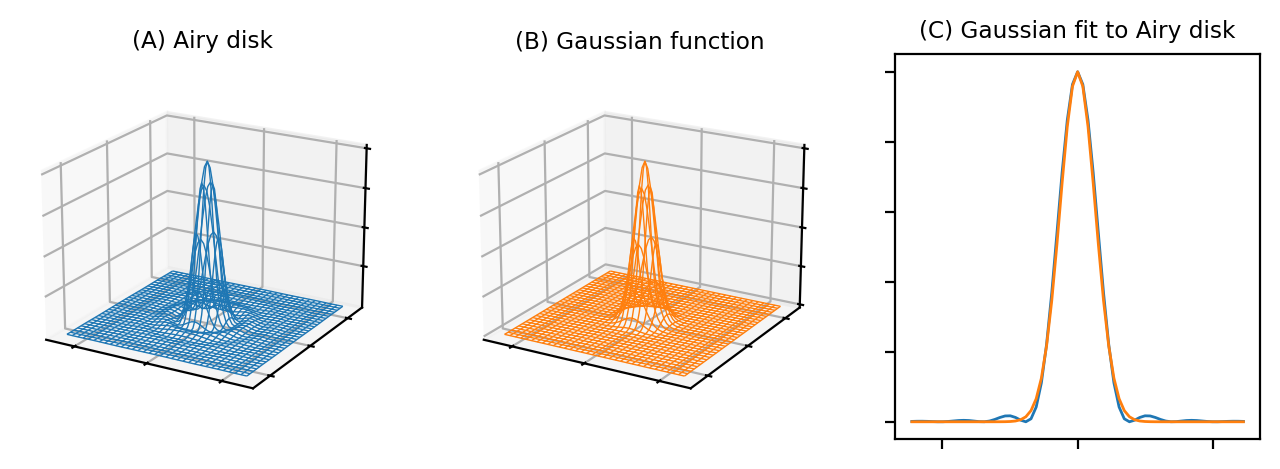

In [7]:
"""
Show 3D plots to compare an Airy disk with a 2D Gaussian function.
"""

# Create an Airy disk image
radius = 10
im_airy, y, x = demo_airy_disk(radius=radius, size = 65)

# Compute FWHM from the Airy disk radius,
# convert to a Gaussian sigma & then create 2D Gaussian
fwhm = radius / 3.232
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
im_gaussian = np.exp(-(x*x + y*y)/(2 * sigma * sigma))

# Show plots
color_airy = '#1f77b4'
color_gaussian = '#ff7f0e'

fig = create_figure(figsize=(8, 2.5))
ax_disk = fig.add_subplot(1, 3, 1, projection='3d', elev=20)
ax_gaussian = fig.add_subplot(1, 3, 2, projection='3d', elev=20)
ax_fit = fig.add_subplot(1, 3, 3)

ax_disk.plot_wireframe(x, y, im_airy, color=color_airy, linewidth=0.5)
ax_gaussian.plot_wireframe(x, y, im_gaussian, color=color_gaussian, linewidth=0.5)

row = im_airy.shape[0]//2
show_plot(y[row, :], im_airy[row, :], color=color_airy, axes=ax_fit)
show_plot(y[row, :], im_gaussian[row, :], color=color_gaussian, axes=ax_fit)

titles = ['(A) Airy disk',
          '(B) Gaussian function',
          '(C) Gaussian fit to Airy disk']
for ax, title in zip([ax_disk, ax_gaussian, ax_fit], titles):
    ax.set_title(title, fontdict={'fontsize':'small'})
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    try:
        ax.set_zticklabels([])
    except:
        pass

glue_fig('fig_blur_psf_surface', fig)

```{glue:figure} fig_blur_psf_surface
---
align: center
name: fig-psf_surface
---
Comparison of an Airy disk and a Gaussian of a similar size, using two wireframe plots and a correspnding 1D cross-section.
The Gaussian is a *very* close match to the Airy disk, apart from the faint ripples at the sides, so we can often approximate the blur of a PSF using a Gaussian filter.
```



## The size of the PSF

So much for appearances.
To judge how the blurring will affect what we can see and measure, we need to know the _size_ of the PSF.
Because we don't tend to want our images to be blurry, smaller would be preferable.

The size requires some defining: the PSF actually continues indefinitely, but has extremely low intensity values when far from its center.
One approach for characterizing the Airy disk size is to consider its radius $r_{airy}$ as the distance from the center to the first _minimum_: the lowest point before the first of the outer ripples begins.
This is is given by:

```{math}
:label: eqn-res_lateral
r_{airy} = \frac{0.61 \lambda}{\textrm{NA}}
```

where $\lambda$ is the light wavelength and NA is the numerical aperture of the objective lens [^fn_1].

[^fn_1]: Note that this is the _limit_ of the Airy disk size, and assumes that the system is free of any aberrations.
In other words, this is the best that we can hope for: the Airy disk cannot be made smaller simply by better focusing, although it could easily be made worse by a less-than-perfect objective lens

A comparable measurement to $r_{airy}$ between the center and first minimum along the *z* axis is:

```{math}
:label: eqn-res_axial
z_{min} = \frac{2 \lambda \times \eta}{\textrm{NA}^2}
```

where $\eta$ is the refractive index of the objective lens immersion medium (which is a value related to the speed of light through that medium).

The practical importance of these equations is that they reveal the key factors that influence how blurry an image will be.
This hints at some ways we might be able to reduce blurring at the acquisition stage.

````{tab-set}

```{tab-item} Question


According to Equation {eq}`eqn-res_lateral`, the equation for the Airy disk size, what are the two variables we _may_ be able to control that influence the amount of blur in our images?
And how must they be changed (increased or decreased) for the images to have less blur?
```

```{tab-item} Answer

If the wavelength $\lambda$ is _lower_ or the objective NA is _higher_, $r_{airy}$ decreases and we have less blur.
```

````

````{tab-set}

```{tab-item} Question


Does the NA have more influence on blur in the *xy* plane, or along the *z* axis?
```


```{tab-item} Answer

Because of the squaring, the NA has a much greater influence on blur along the *z* axis than in *xy*.
This can be seen clearly in {numref}`fig-psf_na`.

```

````

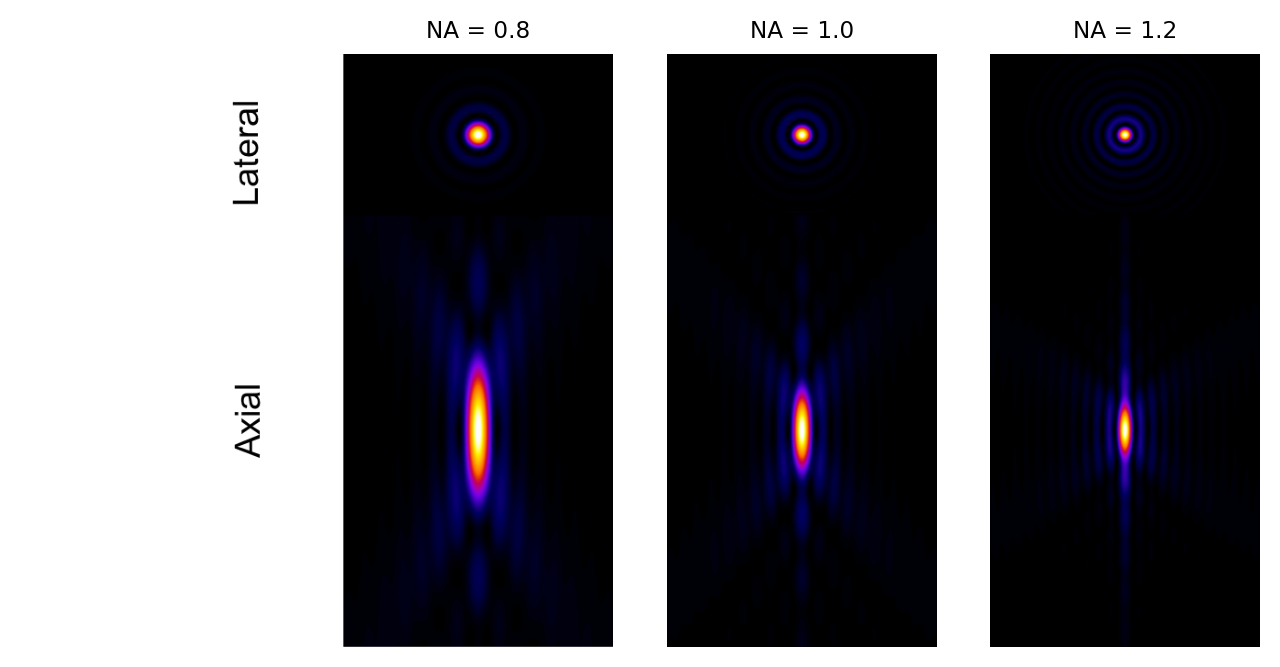

In [8]:
fig = create_figure(figsize=(8, 4))
show_image('images/psf_na_names.png', pos=141)
show_image('images/psf_na_08.png', title='NA = 0.8', pos=142)
show_image('images/psf_na_1.png', title='NA = 1.0', pos=143)
show_image('images/psf_na_12.png', title='NA = 1.2', pos=144)

glue_fig('fig_blur_psf_na', fig)

```{glue:figure} fig_blur_psf_na
---
align: center
name: fig-psf_na
---
Examples of theoretical PSFs generated with different Numerical Apertures.
```


````{margin}
```{image} images/na_theta.png
```
````

````{admonition} Numerical Aperture

The equations for the PSF size show that if you can use an objective lens with a higher NA, you can potentially reduce blur in an image -- especially along the *z* axis ({numref}`fig-psf_na`). Unfortunately, one soon reaches another limit in terms of what increasing the NA can achieve.
This can be seen from the equation used to define it:

```{math}
\textrm{NA} = \eta \sin{\theta}
```

where $\eta$ is again the refractive index of the immersion medium and $\theta$ is the half-angle of the cone of light accepted by the objective.
Because $\sin{\theta}$ can never exceed 1, the NA can never exceed $\eta$, which itself has fixed values (e.g.
around 1.0 for air, 1.34 for water, or 1.5 for oil).
High NA lenses can therefore reduce blur only to a limited degree.

An important additional consideration is that the highest NAs are possible when the immersion refractive index is high, but if this does not match the refractive index of the medium surrounding the sample we get **spherical aberration**.
This is a phenomenon whereby the PSF becomes asymmetrical at increasing depth and the blur becomes weirder.
Therefore, matching the refractive indices of the immersion and embedding media is often _strongly_ preferable to using the highest NA objective available: it's usually better to have a larger PSF than a highly irregular one.

For an interactive tutorial on the effect of using different NAs, see <https://www.microscopyu.com/tutorials/imageformation-airyna>.

````

`````{tab-set}

```{tab-item} Question


Convince yourself that $z_{min}$ will be considerably higher than $r_{airy}$ using one of the following methods:


* Put an example refractive index (e.g. $\eta = 1.34$ for water), and some reasonable values of $\lambda$ and the NA into the equations for the lateral {eq}`eqn-res_lateral` and axial {eq}`eqn-res_axial` resolution, and compare the results
* Calculate the ratio $z_{min} / r_{airy}$ and substitute in the equation for the NA.
This should reveal that the ratio is bigger than 1, i.e. that $z_{min}$ is larger.

What is the main implication of this observation, in terms of how separated structures need to be along different dimensions for them still to be distinguishable?

```


````{tab-item} Answer

The ratio is

```{math}
\frac{z_{min}}{r_{airy}} = \frac{2 \lambda \times \eta}{\textrm{NA}^2} \times \frac{\textrm{NA}}{0.61 \lambda} = \frac{3.28\eta}{\textrm{NA}} = \frac{3.28}{\sin\theta}
```

Therefore, even as $\sin\theta$ becomes close to 1 (i.e.
a very high NA objective is used), the value of $z_{min}$ remains over 3 times larger than $r_{airy}$ -- the *z* resolution is much worse.
When the NA is lower, the difference is even more.

The main practical implication is that it's more likely that you will be able to distinguish structures that are separated from one another by a short distance in *xy* than similarly separated in *z*.
If you really need information along the *z*-dimension more than anywhere else, maybe rotating your sample could help?
````

`````

### Spatial resolution

**Spatial resolution** is concerned with how close two structures can be while they are still distinguishable.
This is a somewhat subjective and fuzzy idea, but one way to define it is by the **Rayleigh Criterion**, according to which two equally bright spots are said to be resolved (i.e. distinguishable) if they are separated by the distances calculated in the lateral {eq}`eqn-res_lateral` and axial {eq}`eqn-res_axial` equations above.
If the spots are closer than this, they are likely to be seen as one.
In the in-focus plane, this is illustrated in {numref}`fig-rayleigh`.

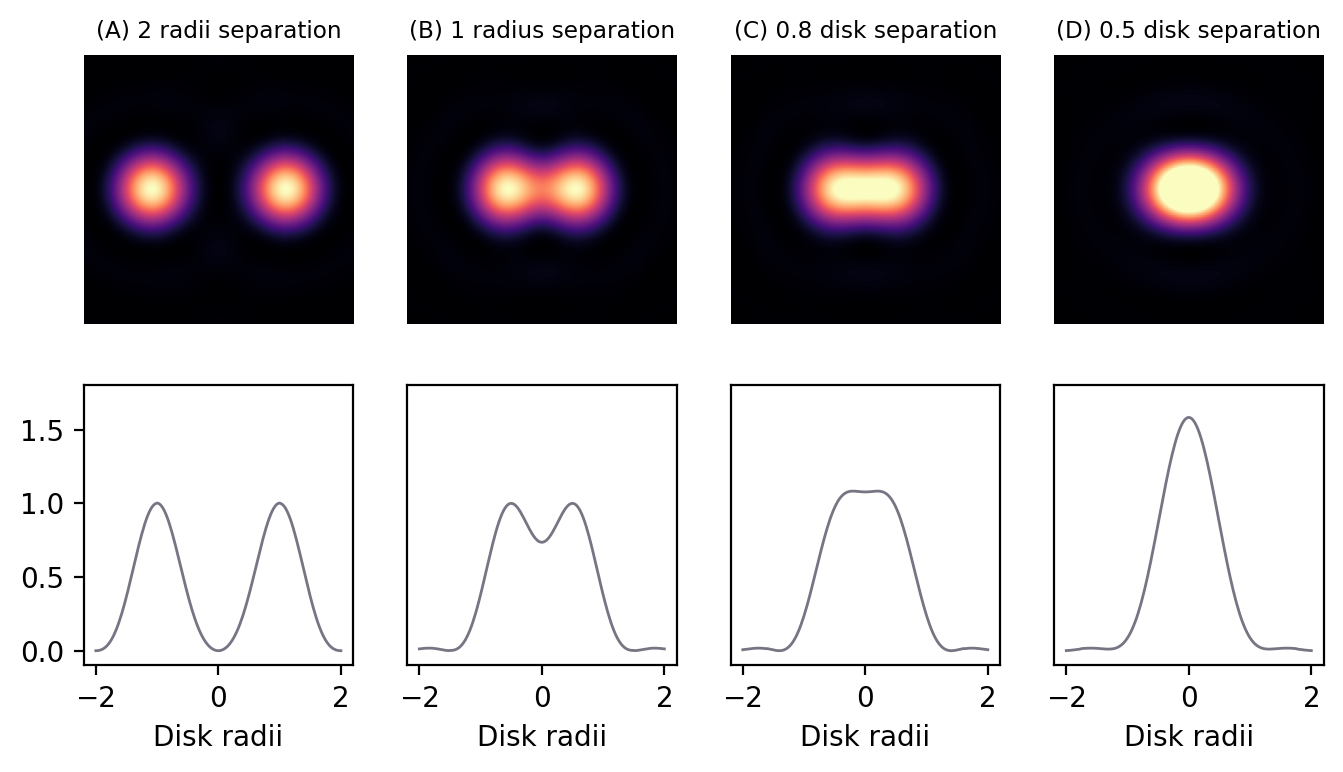

In [9]:

def shift_horizontal(im, n: int):
    """
    Shift an image horizonally left or right, padding with zeros.
    """
    if n == 0:
        return im
    if n > 0:
        return np.pad(im[:, :-n], pad_width=((0, 0), (n, 0)))
    else:
        return np.pad(im[:, -n:], pad_width=((0, 0), (0, -n)))


# Create an Airy disk in a (reasonably) big image
radius = 40
pad = 2
im_airy, x, y = demo_airy_disk(radius=radius, size=radius*pad*2+1)
x = np.arange(-radius*pad, radius*pad+1) / radius
row = im_airy.shape[0]//2

im_airy_2 = shift_horizontal(im_airy, -radius) + shift_horizontal(im_airy, radius)
im_airy_1 = shift_horizontal(im_airy, -radius//2) + shift_horizontal(im_airy, radius//2)
im_airy_0_8 = shift_horizontal(im_airy, -int(radius*0.4)) + shift_horizontal(im_airy, int(radius*0.4))
im_airy_0_5 = shift_horizontal(im_airy, -int(radius*0.25)) + shift_horizontal(im_airy, int(radius*0.25))

# Show plots
fig = create_figure(figsize=(8, 4))

img_args = dict(
    cmap=colormaps['magma'],
    vmin=0,
    vmax=1
)

show_image(im_airy_2, title='(A) 2 radii separation', **img_args, pos=241)
show_image(im_airy_1, title='(B) 1 radius separation', **img_args, pos=242)
show_image(im_airy_0_8, title='(C) 0.8 disk separation', **img_args, pos=243)
show_image(im_airy_0_5, title='(D) 0.5 disk separation', **img_args, pos=244)

plot_args = dict(
    ylim=[-0.1, 1.8],
    xlabel='Disk radii'
)

show_plot(x, im_airy_2[row, :], **plot_args, pos=245)
show_plot(x, im_airy_1[row, :], **plot_args, pos=246)
plt.yticks([])
show_plot(x, im_airy_0_8[row, :], **plot_args, pos=247)
plt.yticks([])
show_plot(x, im_airy_0_5[row, :], **plot_args, pos=248)
plt.yticks([])

glue_fig('fig_blur_rayleigh', fig)

```{glue:figure} fig_blur_rayleigh
---
align: center
name: fig-rayleigh
---
Airy patterns separated by different distances, defined in terms of Airy disk radii. The top row contains the patterns themselves, while the bottom row shows intensity profiles computed across the centers of the patterns. Two distinct spots are clearly visible whenever separated by at least one disk radius, and there is a dip apparent in the profile. However, if the separation is less than one radius, the contrast rapidly decreases until only one structure is apparent. By a separation of 0.5 radii, the two structures appear indistinguishable as a single, brighter structure.
```


It should be kept in mind that the use of $r_{airy}$ and $z_{min}$ in the Rayleigh criterion is somewhat arbitrary -- and the effects of brightness differences, finite pixel sizes and noise further complicate the situation, so that in practice a greater distance may well be required for us to confidently distinguish structures. Nevertheless, the Rayleigh criterion is helpful to give some idea of the scale of distances involved, i.e.
hundreds of nanometers when using visible light.

````{tab-set}

```{tab-item} Question


Suppose the diameter of the Airy disk is around 500 nm, and you are looking at an image containing separate, well-spaced structures that are 2 nm, 20 nm and 200 nm in size.
Assuming that you have imaged all of these exactly in focus (after all, you are a brilliant microscopist), how will these structures appear in the image?

_Note:_ This is a particularly important question! Think of both the size and brightness.

```


```{tab-item} Answer

Because even an infinitesimally small point cannot appear smaller than the Airy disk in the recorded image, _potentially all 3 of these structures look the same!_ There may be _some_ increase in size visible with the 200 nm structure (because it is larger than a single point, this makes it like many different, slightly-shifted-but-mostly-overlapping Airy disks added together), but it will certainly not appear 10 or 100 times larger than the others.

_However_, because smaller objects typically emit fewer photons, the smaller structures may well appear less bright -- if they are bright enough to be visible at all.
Therefore, at this scale accurate measurements of size are impossible from (conventional, non-super-resolution) fluorescence microscopy images, but the actual size may have some relationship with brightness.
```

````

### Measuring PSFs & small structures

Knowing that the Airy disk resembles a Gaussian function is extremely useful, because any time we see an Airy disk we can fit a 2D Gaussian to it.
The parameters of the function will then tell us the Gaussian's center exactly, which corresponds to where the fluorescing structure really is -- admittedly not with complete accuracy, but potentially still beyond the accuracy of even the pixel size (noise is the real limitation).
This idea is fundamental to single-molecule localization techniques, including those in super-resolution microscopes like STORM and PALM, but requires that PSFs are sufficiently well-spaced that they do not interfere with one another and thereby ruin the fitting.

In ImageJ, we can somewhat approximate this localization by drawing a line profile across the peak of a PSF and then running {menuselection}`Analyze --> Tools --> Curve Fitting...`.
There we can fit a 1D Gaussian function, for which the equation used is

```{math}
y = a + (b-a)e^{\frac{-(x-c)^2)}{2d^2}}
```

$a$ is simply a background constant, $b$ tells you the peak amplitude (i.e.
the maximum value of the Gaussian with the background subtracted), and $c$ gives the location of the peak along the profile line.
But potentially the most useful parameter here is $d$, which corresponds to the $\sigma$ value of a Gaussian filter.
So if you know this value for a PSF, you can approximate the same amount of blurring with a Gaussian filter.
This may come in useful in {ref}`chap_macro_simulating`.